Notebook to analyse Nepal tweets and investigate changes in behaviour after earthquake. Better to run the asociated plot_hourly_dist.py script in the background as it takes long time to run! Then read in pickle file with results of that for plotting below.

In [1]:
from IPython.display import Image
import json,glob,collections,datetime,sys
from dateutil import parser
import seaborn as sns
import scipy
import random
import pickle
import traceback
import datetime
import pandas as pd
from hit_detector import HitDetector
from ungpgeo import Geolocator
from bs4 import BeautifulSoup
sns.set_context('paper')
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
hitDetector=HitDetector()
hitDetector.init(path='../data/')

Initialising
../data//NPL_adm1 ../data//NPL_adm0


In [3]:
geo=Geolocator.Geolocator()
geo.init(worldPickleFileName='../geo-world-spark-nepal.pkl',dataFileName='../geo-data/ungp-geo.txt.gz')

Loading the world...
Pickle file found, reading...


In [4]:
res=geo.geoLocate('Pokhara')
assert res[0][3]=='NP'

assert hitDetector.isInCountry((res[0][2],res[0][1]))
assert hitDetector.getRegion((res[0][2],res[0][1]))==(5,'West')

Relevant papers: [Diurnal and Seasonal Mood Vary with Work, Sleep, and Daylength Across Diverse Cultures](http://www.sciencemag.org/content/333/6051/1878.short): measurement of universality of Circadian rythmns globally. Measurement of sleep deprivation after Japanese earthquake [Implications for Social Support on Prolonged Sleep Difficulties among a Disaster-Affected Population](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130615)

1. One baseline per day of the week
2. Only keep in users that are active before the earthquake
3. Consider clustering in social network for social resilience
4. Infer an event? i.e. event detection
5. Compare with OCHA ground truth

In [9]:
def getHourDay(d):
    '''
    Combine getting hour and day into one
    function so we only need to do expensive
    date string parsing once
    '''
    tempDate=d+datetime.timedelta(hours=5,minutes=45)
    # Adjust for Nepal time difference from UTC
    return tempDate.hour,pd.datetime(tempDate.year,tempDate.month,tempDate.day)

In [10]:
def getHourDist(df,d1,d2,norm=False):
    hours=collections.Counter(df[(df.index>d1)&(df.index<d2)].hour.values)
    # Count up distribution of hours in specified range d1-d2
    
    if norm:
        tempSum=float(sum(hours.values()))
        for k,v in hours.items():
            hours[k]=v/tempSum
    
    return hours

In [11]:
def getDevice(t):
    if t:
        return BeautifulSoup(t).text
    else:
        return None

In [12]:
def getLat(l):
    res=geo.geoLocate(l)
    if len(res)>0:
        return res[0][1]

def getLong(l):
    res=geo.geoLocate(l)
    if len(res)>0:
        return res[0][2]

def getLevel(l):
    res=geo.geoLocate(l)
    if len(res)>0:
        return res[0][4]

In [9]:
files=glob.glob('../data/s3-new/stream/DataSift-8fa899ec94816c5c65c32b8fff3c03b0-143*')
print len(files)
files+=glob.glob('../data/s3-new/historic-gap/DataSift-*json')
print len(files)
files+=glob.glob('../data/s3-new/stream-archive/DataSift-*json')
print len(files)

4293
9434
24843


###Main loop through all files: populate dataframe with times of tweets
Sometimes we consider a random subset of all files while prototyping as it can take too long to process

In [10]:
def attemptGeolocation(l):
    if len(l)>0:
        res=geo.geoLocate(l)
        if len(res)>0:
            lat=res[0][1]
            long=res[0][2]
            country=res[0][3]
            level=res[0][4]
            levelIndex=res[0][5]
            return lat,long,level,levelIndex,country
    return None,None,None,None,None

In [11]:
def getLatLong(t):
    lat=None
    long=None
    level=None
    
    try:
        lat=t['twitter']['geo']['latitude']
        level=999 # placemarker for exact geolocation
    except:
        pass
    try:
        long=t['twitter']['geo']['longitude']
    except:
        pass

    return lat,long,level

In [ ]:
users=collections.Counter()

ids=collections.Counter()

hours=collections.Counter()
days=collections.Counter()

hoursBefore=collections.Counter()
hoursAfter=collections.Counter()

fullDf=pd.DataFrame(data={'hour':[]},index=[])

sample=20000

for n,file in enumerate(random.sample(files,sample)):
    if (n%100)==0:print n
    # Take a random sample for now
    with open(file,'r') as inFile:
        timesList=[]
        hoursList=[]
        usersList=[]
        friendsList=[]
        followersList=[]
        locationList=[]
        deviceList=[]
        lats=[]
        longs=[]
        geoLevels=[]
        geoLevelIndices=[]
        countries=[]
        # Keep a list for each file
        # Then update DataFrame
        
        for line in inFile.read().split('\n'):
            t=json.loads(line)
            
            notDuplicate=False
            # We need this flag
            
            if not 'deleted' in t.keys():
                parsedDateTime=parser.parse(t['interaction']['created_at'])
                hour,day=getHourDay(parsedDateTime)
                
                lat,long,level=getLatLong(t)
                # Attempt to get exact GPS coords if possible
                
                #print 'GPS?',lat,long,level
                
                if not 'retweet' in t['twitter'].keys():
                    if not t['interaction']['id'] in ids:
                        notDuplicate=True
                        
                        if pd.datetime(parsedDateTime.year,parsedDateTime.month,parsedDateTime.day,0,0)<pd.datetime(2015,4,25):
                            hoursBefore[hour]+=1
                        else:
                            hoursAfter[hour]+=1
                        
                        users[t['twitter']['user']['screen_name']]+=1
                        usersList.append(t['twitter']['user']['screen_name'])
                        friendsList.append(t['twitter']['user']['friends_count'])
                        followersList.append(t['twitter']['user']['followers_count'])

                        try:
                            locationList.append(t['twitter']['user']['location'].lower())
#                            lat,long,level,levelIndex=attemptGeolocation(locationList[-1])
                        except:
                            locationList.append('')
                        #    print '!!!',traceback.print_exc()
                            
                        ids[t['interaction']['id']]+=1
                        
                        hours[hour]+=1
                        days[day]+=1
                        timesList.append(parsedDateTime)
                        hoursList.append(hour)
                        deviceList.append(t['twitter'].get('source'))
                else:

                    if not t['interaction']['id'] in ids:
                        notDuplicate=True
                        
                        if pd.datetime(parsedDateTime.year,parsedDateTime.month,parsedDateTime.day,0,0)<pd.datetime(2015,4,25):
                            hoursBefore[hour]+=1
                        else:
                            hoursAfter[hour]+=1

                        users[t['twitter']['retweet']['user']['screen_name']]+=1
                        usersList.append(t['twitter']['retweet']['user']['screen_name'])
                        friendsList.append(t['twitter']['retweet']['user']['friends_count'])
                        followersList.append(t['twitter']['retweet']['user']['followers_count'])
                        
                        try:
                            locationList.append(t['twitter']['retweet']['user']['location'].lower())
#                            lat,long,level,levelIndex=attemptGeolocation(locationList[-1])
                        except:
                            locationList.append('')
                        
                        ids[t['interaction']['id']]+=1
                        
                        hour,day=getHourDay(parsedDateTime)
                        hours[hour]+=1
                        days[day]+=1
                        timesList.append(parsedDateTime)
                        hoursList.append(hour)
                        deviceList.append(t['twitter'].get('source'))
                if not level and notDuplicate:
                    # If there are no GPS coords, attempt geolocation of location string
                    lat,long,level,levelIndex,country=attemptGeolocation(locationList[-1])
                    
                if notDuplicate:
                    lats.append(lat)
                    longs.append(long)
                    geoLevels.append(level)
                    geoLevelIndices.append(levelIndex)
                    countries.append(country)
                    # Add location information, 
                    # whether from GPS or GeoNames

#    print ' '.join([str(len(l)) for l in [usersList,hoursList,friendsList,followersList,deviceList,locationList,lats,longs,geoLevels,geoLevelIndices,countries]])
    
    tempDf=pd.DataFrame(data={'user':usersList,'hour':hoursList,'friends':friendsList,'followers':followersList,
    'device':deviceList,'location':locationList,'lat':lats,'long':longs,'level':geoLevels,
    'country':countries,'levelIndices':geoLevelIndices,'latLong':zip(longs,lats)},index=timesList)
    
    fullDf=pd.concat([fullDf,tempDf])
    if n==-999:sys.exit(1)

In [29]:
fullDf.head()

,country,device,followers,friends,hour,lat,latLong,level,levelIndices,location,long,user
2015-05-29 17:27:27+00:00,NP,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",420,503,23,28,"(84.0, 28.0)",1,00,nepal,84,amrebel
2015-05-29 17:27:27+00:00,NP,"<a href=""http://twitter.com/download/android"" ...",735,332,23,27.70704,"(85.33218, 27.70704)",2,CR,"kathmandu,nepal(मन्जाङ लमजुङ)",85.33218,asishsir
2015-05-29 17:27:27+00:00,RU,None,2725,1368,23,56.8519,"(60.6122, 56.8519)",3,71,екатеринбург-первоуральск:-),60.6122,latnick65
2015-05-29 17:27:28+00:00,US,None,131,310,23,43.00035,"(-75.4999, 43.00035)",2,NY,"new york, new york",-75.4999,rnothps
2015-05-29 17:27:29+00:00,NP,"<a href=""http://twitter.com/download/iphone"" r...",533,101,23,27.70055,"(83.44836, 27.70055)",3,WR,"butwal,nepal",83.44836,anupanthi7


In [33]:
fullDf.level.value_counts()
# 999=GPS geolocation, 1=country, 2=region

3      264708
2      215472
1      187975
999     53435
dtype: int64

Some geolocation hacks   
- craftmandu
- k-town
- quakemandu 
- नेपाल (nepal)
- नेपाल (nepal)
- cat-man-do (nepal)
- झुले–४, दोलखा (dolakha)
- काठमाडौं (kathmandu)
-  दोलखा (dolakha)
- भरतपुर (Bharatpur)
- सिन्धुली (sindhuli)

In [ ]:
fullDf[pd.isnull(fullDf.level)].location.value_counts()

In [25]:
%time fullDf['region']=fullDf.latLong.apply(lambda x:hitDetector.getRegion(x)[0])

CPU times: user 1min 46s, sys: 27.8 ms, total: 1min 46s
Wall time: 1min 46s


In [27]:
print fullDf.shape[0]
fullDf.region.value_counts()

4441


5    1337
1    1300
2     139
4      26
3      17
dtype: int64

###Look at geographical dsitribution, CR=central region etc ([see](https://en.wikipedia.org/wiki/Administrative_divisions_of_Nepal#Development_regions_of_Nepal))

In [36]:
fullDf[fullDf.levelIndices=='CR'].level.value_counts()

3      140980
2      138178
999     15489
dtype: int64

In [65]:
fullDf[fullDf.country=='NP'].levelIndices.value_counts()

CR    1300
00     953
WR     302
ER     124
MR      19
FR      18
dtype: int64

###Persist

In [190]:
with open('df_3.out','w') as outFile:
    pickle.dump(fullDf,outFile)

###Read pickle file back in here for plotting

In [2]:
%%time
with open('df_3.out','r') as inFile:
    fullDf=pickle.load(inFile)

CPU times: user 8min 8s, sys: 11.3 s, total: 8min 19s
Wall time: 8min 19s


In [3]:
beforeUsers=fullDf[fullDf.index<pd.datetime(2015,4,25)].user

In [4]:
beforeUsersAfter=fullDf[(fullDf.user.isin(beforeUsers.values))&(fullDf.index>pd.datetime(2015,4,25))]

In [5]:
print '%d tweets after quake out of %d by users active before quake (%.2f%%)' % \
(beforeUsersAfter.shape[0],fullDf[fullDf.index>pd.datetime(2015,4,25)].shape[0],float(beforeUsersAfter.shape[0])/fullDf[fullDf.index>pd.datetime(2015,4,25)].shape[0])

8865168 tweets after quake out of 12499274 by users active before quake (0.71%)


In [6]:
print '%d distinct users before and %d distinct users after (%.2f%%)' % \
(pd.unique(beforeUsers).shape[0],\
 pd.unique(fullDf[fullDf.index>pd.datetime(2015,4,25)].user).shape[0],\
 float(pd.unique(beforeUsers).shape[0])/pd.unique(fullDf[fullDf.index>pd.datetime(2015,4,25)].user).shape[0])

282472 distinct users before and 584821 distinct users after (0.48%)


###Plot time series

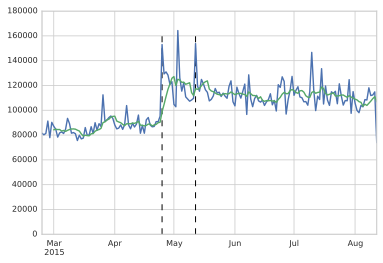

In [7]:
daily=fullDf.resample('D',how='count')['hour']
daily.plot()
pd.rolling_mean(daily,7).plot()
plt.vlines(pd.datetime(2015,4,25),0,160000,linewidth=1,linestyle='--')
plt.vlines(pd.datetime(2015,5,12),0,160000,linewidth=1,linestyle='--')
plt.savefig('../charts/full_time_series.png',dpi=200)
#pd.rolling_mean(fullDf['hour'],5).plot()
#tempDf.resample('d',how='count').plot()

### Consider hourly distribution of tweets per day: calculate Euclidian distance from a 7 baseline well before earthquake. Store in lists to plot later
7 day baseline is important as the pattern varies a lot throughout the weekend

2015-03-02 00:00:00+00:00 2015-03-03 00:00:00+00:00
(84754, 11)
0:0.02 1:0.02 2:0.01 3:0.01 4:0.01 5:0.01 6:0.03 7:0.04 8:0.05 9:0.05 10:0.06 11:0.05 12:0.05 13:0.05 14:0.05 15:0.05 16:0.05 17:0.06 18:0.06 19:0.05 20:0.07 21:0.06 22:0.05 23:0.03
2015-03-03 00:00:00+00:00 2015-03-04 00:00:00+00:00
(78368, 11)
0:0.02 1:0.02 2:0.01 3:0.02 4:0.01 5:0.02 6:0.02 7:0.04 8:0.05 9:0.05 10:0.05 11:0.06 12:0.04 13:0.05 14:0.04 15:0.05 16:0.05 17:0.06 18:0.05 19:0.06 20:0.07 21:0.06 22:0.06 23:0.04
2015-03-04 00:00:00+00:00 2015-03-05 00:00:00+00:00
(81749, 11)
0:0.03 1:0.02 2:0.02 3:0.02 4:0.01 5:0.02 6:0.03 7:0.04 8:0.05 9:0.05 10:0.05 11:0.05 12:0.04 13:0.05 14:0.05 15:0.05 16:0.05 17:0.05 18:0.05 19:0.06 20:0.07 21:0.06 22:0.05 23:0.04
2015-03-05 00:00:00+00:00 2015-03-06 00:00:00+00:00
(82554, 11)
0:0.03 1:0.02 2:0.01 3:0.01 4:0.01 5:0.02 6:0.03 7:0.05 8:0.06 9:0.06 10:0.05 11:0.05 12:0.05 13:0.04 14:0.05 15:0.05 16:0.04 17:0.05 18:0.05 19:0.06 20:0.06 21:0.06 22:0.05 23:0.03
2015-03-06 00:00

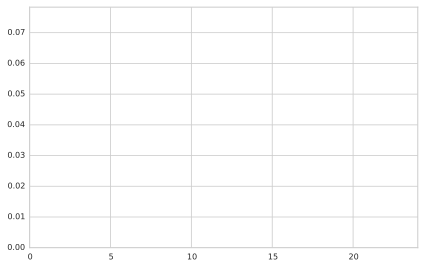

In [13]:
smoothing='d'

days=pd.date_range(start=fullDf.index.min(),end=fullDf.index.max(),freq=smoothing,normalize=True)

burnin=7
# Window to calculate baseline
baseline=getHourDist(fullDf,days[0],days[burnin],norm=True)

distanceTimes=[]
distances=[]

for d1,d2 in zip(days[burnin:-1],days[burnin+1:]):
    chosenColour='blue'
    if pd.datetime(2015,d2.month,d2.day)>pd.datetime(2015,4,25):
        chosenColour='red'
    # AFter the earthquake, plot in red
        
    print d1,d2
    distanceTimes.append(d1)
    
    subset=fullDf[(fullDf.index>d1)&(fullDf.index<d2)&(fullDf.user.isin(beforeUsers))]
    # Condition is for tweets in time range and also 
    # from a user that was active before the quake
    
    print subset.shape
#    print getHourDist(fullDf,d1,d2,norm=True).values()

    hourDist=getHourDist(fullDf,d1,d2,norm=True)
    
    if len(hourDist.values())>0:
        # In case sub sample leads to zero values
        
        distances.append(scipy.spatial.distance.euclidean([baseline[i] for i in range(24)],[hourDist[i] for i in range(24)]))
        
        print ' '.join(['%d:%.2f' % (kk,vv) for kk,vv in hourDist.items()])
        plt.bar(range(24),[hourDist[i] for i in range(24)],width=0.8,alpha=0.5,color=chosenColour)
        plt.xlim(0,24)
        plt.ylim(0.0,max(hourDist.values()))
        plt.title(d1.strftime('%m-%d')+' (n='+str(subset.shape[0])+' dist=%.2f)' % (distances[-1]))  
        plt.tight_layout()
        plt.savefig('../charts/hour_dist_'+d1.strftime('%m-%d')+'.png',dpi=200)
#        plt.show()
        plt.cla()
        
    else:
        distances.append(0.0)


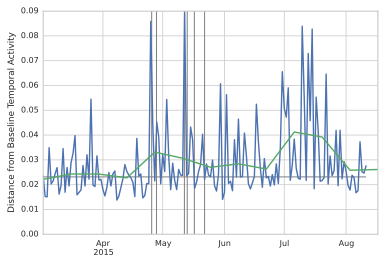

In [14]:
distanceDf=pd.DataFrame(data={'distances':distances},index=distanceTimes)
distanceDf.plot(legend=False)
distanceDf.resample('2W',how='mean')['distances'].plot()

beforeMeanValue=distanceDf[distanceDf.index<pd.datetime(2015,4,25)]['distances'].mean()
beforeStdValue=distanceDf[distanceDf.index<pd.datetime(2015,4,25)]['distances'].std()
percentile25=scipy.percentile(distanceDf.distances.values,25)
percentile50=scipy.percentile(distanceDf.distances.values,50)
percentile75=scipy.percentile(distanceDf.distances.values,75)

plt.hlines(beforeMeanValue,distanceDf.index.min(),distanceDf.index.max(),linewidth=1,color='gray')
#plt.hlines(percentile25,distanceDf.index.min(),distanceDf.index.max(),linewidth=1,color='gray',linestyle='--')
#plt.hlines(percentile75,distanceDf.index.min(),distanceDf.index.max(),linewidth=1,color='gray',linestyle='--')

timeDiff=datetime.timedelta(hours=5,minutes=45)
plt.vlines(pd.datetime(2015,4,25,11,56),0,0.7,linewidth=1,color='gray')#,linestyle='dashdot')
plt.vlines(pd.datetime(2015,4,27,21,36),0,0.7,linewidth=1,color='gray')#,linestyle='dashdot') #4.5 Kathmandu
plt.vlines(pd.datetime(2015,5,11,21,57),0,0.7,linewidth=1,color='gray')#,linestyle='dashdot') #5.3
plt.vlines(pd.datetime(2015,5,13,7,56),0,0.7,linewidth=1,color='gray')#,linestyle='dashdot') # 5.2
plt.vlines(pd.datetime(2015,5,16,21,56),0,0.7,linewidth=1,color='gray')#,linestyle='dashdot')
plt.vlines(pd.datetime(2015,5,22),0,0.7,linewidth=1,color='gray')#,linestyle='dashdot') #3.7 in Kathmandu
plt.ylabel('Distance from Baseline Temporal Activity')
plt.ylim(0.0,0.09)
plt.savefig('../charts/hour_dist_distance_series.png',dpi=300)

###Some User Stats

In [15]:
users=collections.Counter(fullDf.user.values)
print 'Top users',users.most_common(5)
print '--------------------'
print '%.1fk total users' % (len(users.keys())/1000.0)
print '%.1fm tweets in total' % (sum(users.values())/1000000.0)

Top users [(u'everyNepaliNo', 236078), (u'Team_Viken', 152802), (u'rssworldnews', 137124), (u'tshering99', 90267), (u'BrkNews365', 65397)]
--------------------
773.3k total users
17.8m tweets in total


###Distribution of region for all Nepal tweets 
00 means the country as a whole

In [22]:
fullDf[fullDf.country=='NP'].levelIndices.value_counts()

CR    5033018
00    3378537
WR    1090548
ER     473466
MR      93706
FR      46726
dtype: int64

In [16]:
plt.bar(range(24),hours.values(),width=0.8)
plt.xlim(0,24)
plt.xlabel('Hour of Day')
plt.ylabel('Tweets per Hour')

NameError: name 'hours' is not defined

###Normalise

In [183]:
afterSum=sum(hoursAfter.values())
for k,v in hoursAfter.items():
    hoursAfter[k]=v/float(afterSum)
    
beforeSum=sum(hoursBefore.values())
for k,v in hoursBefore.items():
    hoursBefore[k]=v/float(beforeSum)

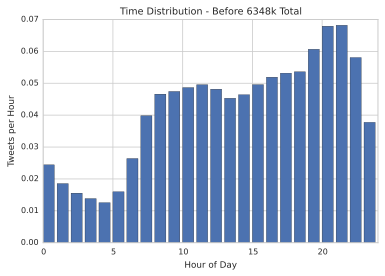

In [184]:
plt.bar(range(24),hoursBefore.values(),width=0.8)
plt.xlim(0,24)
plt.title('Time Distribution - Before %dk Total' % (beforeSum/1000.0))
plt.xlabel('Hour of Day')
plt.ylabel('Tweets per Hour')

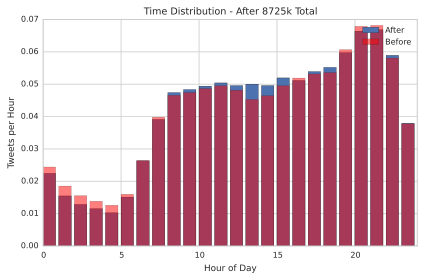

In [185]:
plt.bar(range(24),hoursAfter.values(),width=0.8,label='After')
plt.bar(range(24),hoursBefore.values(),width=0.8,color='red',alpha=0.5,label='Before')
plt.xlim(0,24)
plt.title('Time Distribution - After %dk Total' % (afterSum/1000.0))
plt.xlabel('Hour of Day')
plt.ylabel('Tweets per Hour')
plt.legend()
plt.tight_layout()
plt.savefig('../charts/hour_dist_before_after.png',dpi=200)